In [1]:
from dataclasses import dataclass
from typing import Optional, Union, List
import numpy as np
import gym
import gym.spaces
import gym.envs.registration
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from PIL import Image, ImageDraw

import utils
from solutions import *

MAIN = __name__ == "__main__"

In [2]:
ObsType = int
ActType = int

class DiscreteEnviroGym(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete

    def __init__(self, env: Environment):
        super().__init__()
        self.env = env
        self.observation_space = gym.spaces.Discrete(env.num_states)
        self.action_space = gym.spaces.Discrete(env.num_actions)
        self.reset()

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        '''
        Samples from the underlying dynamics of the environment
        '''
        (states, rewards, probs) = self.env.dynamics(self.pos, action)
        idx = self.np_random.choice(len(states), p=probs)
        (new_state, reward) = (states[idx], rewards[idx])
        self.pos = new_state
        done = self.pos in self.env.terminal
        return (new_state, reward, done, {"env": self.env})

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        super().reset(seed=seed)
        self.pos = self.env.start
        return (self.pos, {"env": self.env}) if return_info else self.pos

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"

In [3]:
gym.envs.registration.register(
    id="NorvigGrid-v0",
    entry_point=DiscreteEnviroGym,
    max_episode_steps=100,
    nondeterministic=True,
    kwargs={"env": Norvig(penalty=-0.04)},
)

gym.envs.registration.register(
    id="ToyGym-v0", 
    entry_point=DiscreteEnviroGym, 
    max_episode_steps=2, 
    nondeterministic=False, 
    kwargs={"env": Toy()}
)

In [4]:
@dataclass
class Experience:
    '''A class for storing one piece of experience during an episode run'''
    obs: ObsType
    act: ActType
    reward: float
    new_obs: ObsType
    new_act: Optional[ActType] = None

@dataclass
class AgentConfig:
    '''Hyperparameters for agents'''
    epsilon: float = 0.1
    lr: float = 0.05
    optimism: float = 0

defaultConfig = AgentConfig()

class Agent:
    '''Base class for agents interacting with an environment (you do not need to add any implementation here)'''
    rng: np.random.Generator

    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma: float = 0.99, seed: int = 0):
        self.env = env
        self.reset(seed)
        self.config = config
        self.gamma = gamma
        self.num_actions = env.action_space.n
        self.num_states = env.observation_space.n
        self.name = type(self).__name__

    def get_action(self, obs: ObsType) -> ActType:
        raise NotImplementedError()

    def observe(self, exp: Experience) -> None:
        '''
        Agent observes experience, and updates model as appropriate.
        Implementation depends on type of agent.
        '''
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

    def run_episode(self, seed) -> List[int]:
        '''
        Simulates one episode of interaction, agent learns as appropriate
        Inputs:
            seed : Seed for the random number generator
        Outputs:
            The rewards obtained during the episode
        '''
        rewards = []
        obs = self.env.reset(seed=seed)
        self.reset(seed=seed)
        done = False
        while not done:
            act = self.get_action(obs)
            (new_obs, reward, done, info) = self.env.step(act)
            exp = Experience(obs, act, reward, new_obs)
            self.observe(exp)
            rewards.append(reward)
            obs = new_obs
        return rewards

    def train(self, n_runs=500):
        '''
        Run a batch of episodes, and return the total reward obtained per episode
        Inputs:
            n_runs : The number of episodes to simulate
        Outputs:
            The discounted sum of rewards obtained for each episode
        '''
        all_rewards = []
        for seed in trange(n_runs):
            rewards = self.run_episode(seed)
            all_rewards.append(utils.sum_rewards(rewards, self.gamma))
        return all_rewards

class Random(Agent):
    def get_action(self, obs: ObsType) -> ActType:
        return self.rng.integers(0, self.num_actions)

/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
  0%|          | 0/100 [00:00<?, ?it/s]/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecat

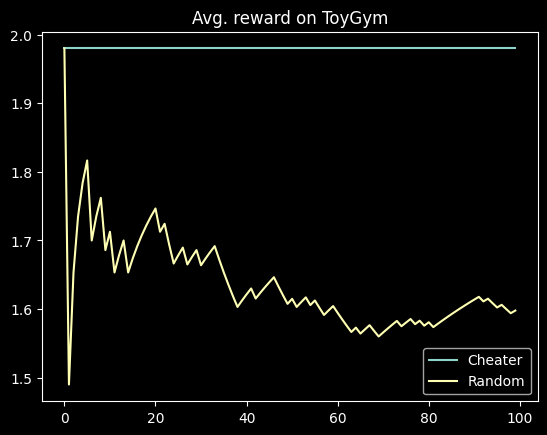

In [5]:
from bellman_equation_solutions import find_optimal_policy

class Cheater(Agent):
    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma=0.99, seed=0):
        self.env = env
        self.reset(seed)
        self.config = config
        self.gamma = gamma
        self.num_actions = env.action_space.n
        self.num_states = env.observation_space.n
        self.name = type(self).__name__
        self.policy = find_optimal_policy(self.env.unwrapped.env, gamma)

    def get_action(self, obs):
        return self.policy[obs]
    

if MAIN:
    env_toy = gym.make("ToyGym-v0")
    agents_toy = [Cheater(env_toy), Random(env_toy)]
    for agent in agents_toy:
        returns = agent.train(n_runs=100)
        plt.plot(utils.cummean(returns), label=agent.name)
    plt.legend()
    plt.title(f"Avg. reward on {env_toy.spec.name}")
    plt.show()

In [6]:
class EpsilonGreedy(Agent):
    '''
    A class for SARSA and Q-Learning to inherit from.
    '''

    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma: float = 0.99, seed: int = 0):
        super().__init__(env, config, gamma, seed)
        


    def get_action(self, obs: ObsType) -> ActType:
        '''
        Selects an action using epsilon-greedy with respect to Q-value estimates
        '''
        pivot = self.rng.random()
        if pivot > self.config.epsilon:
            return self.get_optimal_policy(obs)
        else:
            return self.rng.integers(0, self.num_actions) # assume discrete action space

    def get_optimal_policy(self, obs):
        return "Takes optimal policy given obs"
        
    def reset(self,seed):
        super().reset(seed)
        
        
agent = EpsilonGreedy(env = env_toy)


In [7]:
# obs: ObsType
# act: ActType
# reward: float
# new_obs: ObsType
# new_act: Optional[ActType] = None

class SARSA(EpsilonGreedy):
    
    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma: float = 0.99, seed: int = 0):
        super().__init__(env, config, gamma, seed) 
        if self.config.optimism:
            self.Q = np.ones((self.num_states, self.num_actions))*self.config.optimism
        else:
            self.Q = np.zeros((self.num_states, self.num_actions))

    def get_optimal_policy(self, obs):
        return np.argmax(self.Q[obs, :])

    def observe(self, exp: Experience) -> None:
        self.Q[exp.obs, exp.act] += self.config.lr*(exp.reward + self.gamma*self.Q[exp.new_obs, exp.new_act] - self.Q[exp.obs, exp.act])

    def run_episode(self, seed) -> List[int]:
        '''
        Simulates one episode of interaction, agent learns as appropriate
        Inputs:
            seed : Seed for the random number generator
        Outputs:
            The rewards obtained during the episode
        '''
        rewards = []
        obs = self.env.reset(seed=seed)
        self.reset(seed=seed)
        done = False
        new_act = self.get_action(obs)
        while not done:
            act = new_act
            (new_obs, reward, done, info) = self.env.step(act)
            new_act = self.get_action(new_obs)
            exp = Experience(obs, act, reward, new_obs, new_act)
            self.observe(exp)
            rewards.append(reward)
            obs = new_obs
        return rewards
    
class QLearning(EpsilonGreedy):
    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma: float = 0.99, seed: int = 0):
        super().__init__(env, config, gamma, seed) 
        if self.config.optimism:
            self.Q = np.ones((self.num_states, self.num_actions))*self.config.optimism
        else:
            self.Q = np.zeros((self.num_states, self.num_actions))

    def get_optimal_policy(self, obs):
        return np.argmax(self.Q[obs, :])

    def observe(self, exp: Experience) -> None:
        self.Q[exp.obs, exp.act] += self.config.lr*(exp.reward + self.gamma*np.max(self.Q[exp.new_obs,:])- self.Q[exp.obs, exp.act])
    



100%|██████████| 1000/1000 [00:01<00:00, 661.92it/s]


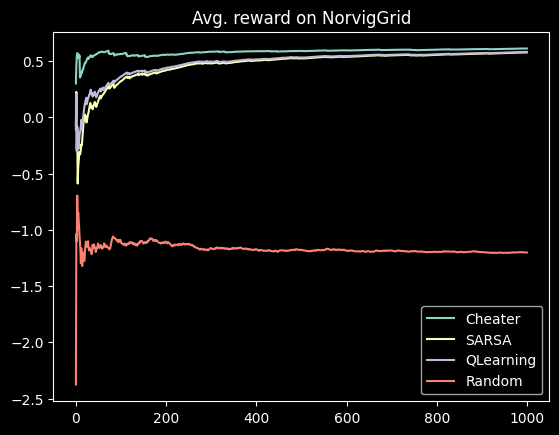

In [8]:
if MAIN:
    env_norvig = gym.make("NorvigGrid-v0")
    config_norvig = AgentConfig(epsilon=0.0)
    n_runs = 1000
    gamma = 0.99
    seed = 1
    args_nor = (env_norvig, config_norvig, gamma, seed)
    agents_norvig = [Cheater(*args_nor), SARSA(*args_nor), QLearning(*args_nor), Random(*args_nor)]
    returns_norvig = {}
    for agent in agents_norvig:
        returns_norvig[agent.name] = agent.train(n_runs)
if MAIN:
    for agent in agents_norvig:
        name = agent.name
        plt.plot(utils.cummean(returns_norvig[name]), label=name)
    plt.legend()
    plt.title(f"Avg. reward on {env_norvig.spec.name}")
    plt.show()

/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
100%|██████████| 1000/1000 [00:00<00:00, 3663.20it/s]


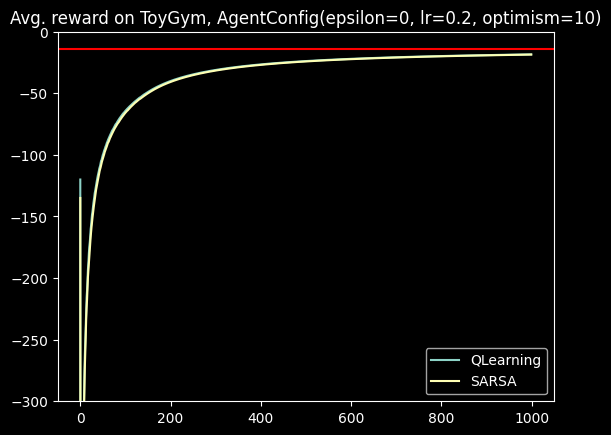

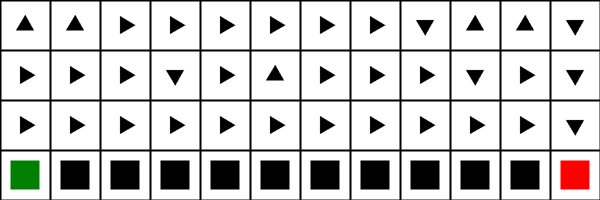

/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



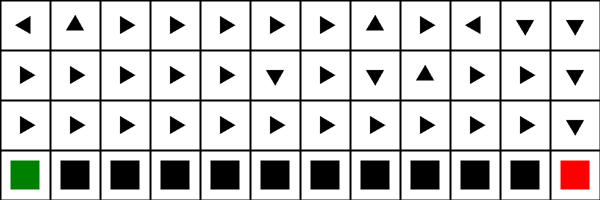

In [9]:
import plotly.express as px 

def show_cliff_value(Q: Arr, title: Optional[str] = None):
    '''
    Displays the value of each state in CliffWalking-v0 given a Q-value table.
    '''
    V = Q.max(axis=-1).reshape(4, 12)
    fig = px.imshow(V, text_auto=".2f", title=title)
    fig.show()

def show_cliff_policy(Q: Arr):
    '''
    Displays the greedy policy for CliffWalking-v0 given a Q-value table.
    '''
    pi = Q.argmax(axis=-1).reshape((4, 12))
    objects = {(3, 0): "green", (3, 11): "red"} | {(3, i): "black" for i in range(1, 11)}
    img = Image.new(mode="RGB", size=(1200, 400), color="white")
    draw = ImageDraw.Draw(img)
    for x in range(0, img.width+1, 100):
        draw.line([(x, 0), (x, img.height)], fill="black", width=4)
    for y in range(0, img.height+1, 100):
        draw.line([(0, y), (img.width, y)], fill="black", width=4)
    for x in range(12):
        for y in range(4):
            draw.regular_polygon((50+x*100, 50+y*100, 20), 3, rotation=-int(90*pi[y][x]), fill="black")
            if (y, x) in objects:
                draw.regular_polygon((50+x*100, 50+y*100, 40), 4, fill=objects[(y, x)])
    display(img.resize((600, 200)))

if MAIN:
    env = gym.make("CliffWalking-v0")
    config = AgentConfig(epsilon=0, lr=0.2, optimism=10)
    n_runs = 1000
    gamma = 1
    seed = 1
    args_nor = (env, config, gamma, seed)
    agents = [QLearning(*args_nor), SARSA(*args_nor)]
    returns  = {}
    for agent in agents:
        returns[agent.name] = agent.train(n_runs)
if MAIN:
    for agent in agents:
        name = agent.name
        plt.plot(utils.cummean(returns[name]), label=name)
    plt.legend()
    plt.axhline(y=-14, color='r', linestyle='-')
    plt.title(f"Avg. reward on {env_toy.spec.name}, {config}")
    plt.ylim(-300,0)
    plt.show()
    for agent in agents:
        show_cliff_policy(agent.Q)
        show_cliff_value(agent.Q)